In [1]:
import argparse
import json
import logging
import sys

import copy
import numpy as np
import pandas as pd
import pdb

import glob
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import loki
from loki.util import constraints, postprocessing
from loki.solver import sat
from loki.util.postprocessing import *

%load_ext autoreload
%autoreload 2

In [2]:
## add progress bar showing upload to postgres
## print out some model variables while sat solving
## remove error messages

# Setting up parameters

In [3]:
os.chdir("/flash1/pari/loki")
parser = argparse.ArgumentParser(description='Run Loki.')
parser.add_argument('--config', '-c', default='application.conf')
parser.add_argument('--workload', '-w', default='imdb')
parser.add_argument('--table', '-t', default='n')
parser.add_argument('--vars_per_col', '-n', default=1000)
parser.add_argument('--logfile', '-lf', default='logs/loki.log')
parser.add_argument('--verbose', '-v', default=False, action='store_true')
#args = parser.parse_args()
args = parser.parse_args(args=[])

# Input Files (IR of Parsed Query Workload)

In [4]:
loki.load_config(args.config)
c_df = pd.read_csv(loki.config[args.workload]['constraints_df'])
c_df = c_df.sample(frac=0.1)
c_df.head(5)

,exprhash,RowCount,InputCardinality,RowSql,Column,input,jobid,Op,Value,Selectivity
69205,649061936416138436151139749307330939157026280984,1,12,SELECT COUNT(*) from role_type AS rt WHERE rt....,rt.role,rt,2672,=,'guest',0.083333
50530,230827535587123430185529326871021005948565506841,184,234997,SELECT COUNT(*) from company_name AS cn WHERE ...,cn.country_code,cn,1967,=,'[cu]',0.000783
79467,1003400726974486748443596839913984107539417056587,2456181,2528312,SELECT COUNT(*) from title AS t WHERE t.produc...,t.production_year,t,3067,<=,2015,0.971471
50017,1379668773053104941044712301249542214133758072397,15,2528312,SELECT COUNT(*) from title AS t WHERE t.title ...,t.title,t,1949,=,'Night Club',0.000006
62418,927402910388058560381898653100772105839030995975,1,12,SELECT COUNT(*) from role_type AS rt WHERE rt....,rt.role,rt,2415,=,'director',0.083333


In [8]:
constraints_df.keys()

Index(['exprhash', 'RowCount', 'InputCardinality', 'RowSql', 'Column', 'input',
       'jobid', 'Op', 'Value', 'Selectivity', 'opstring', 'Column0', 'Column1',
       'Op0', 'Op1', 'Value0', 'Value1'],
      dtype='object')

# Converting the cardinalities ---> SAT constraints, and solving it for a potential database that satisfies those constraints

In [5]:
import warnings
warnings.filterwarnings('ignore')
import time

start = time.time()
logging.basicConfig(
    level=logging.DEBUG if args.verbose else logging.INFO,
    format="%(asctime)s %(levelname)-8s [%(name)s]  %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(args.logfile), logging.StreamHandler()])

logger = logging.getLogger('stdout')

#logger.info('Loki initialized with configuration:\n%s' % json.dumps(loki.config, sort_keys=True, indent=4))

print('Loki initialized with configuration: \n{}'.format(json.dumps(loki.config, sort_keys=True, indent=4)))
df = pd.read_csv(loki.config[args.workload]['df'])
tables = set(df['input'])
table_columns = {table: set(df['column'].where(df['input'] == table).dropna()) for table in tables}

table = args.table
orig_table = table
# table = '"{}"'.format(table)

columns = table_columns[table]

constraints_df = constraints.get_constraints_df(c_df, table)
print("Operators used: ", set(constraints_df["Op"]))

table_cardinality = constraints.get_table_cardinality(constraints_df)
co_optimized_columns = constraints.get_co_optimized_columns(constraints_df, columns)
programs = constraints.get_programs(co_optimized_columns)

leftover_constraints = []

vars_per_col = args.vars_per_col

solutions = []

constraints_df = constraints_df[constraints_df["Value0"] != "None"]
constraints_df = constraints_df[constraints_df["Value1"] != "None"]
constraints_df = constraints_df[constraints_df["Value"] != "None"]
# pdb.set_trace()
for program in programs:
    #logger.info(f'Solving: {program}')
    print(f'Solving: {program}')
    constraints_ = constraints.parse_constraints(program, constraints_df)
    model, vars, cols, col_values_ids_map = sat.build_model(program, constraints_, leftover_constraints, table_cardinality, vars_per_col)
    solution = sat.solve(model, vars, cols, col_values_ids_map, vars_per_col)
    solutions.append(solution)
    #logger.info(f'Solved: {program}')
    print(f'Solved: {program}')

# Combine all programs' solutions into a single dictionary solution
full_solution = {k: v for s in solutions for k, v in s.items()}

postprocessing.apply_leftover_constraints(full_solution, leftover_constraints)
solution_df = postprocessing.solution_to_df(full_solution)
final_solution_df = postprocessing.scale_solution_df(solution_df, table_cardinality, vars_per_col)

final_solution_df.to_csv(f'results/{orig_table}.csv')

print("Generating solutions took: ", time.time()-start)

Loki initialized with configuration: 
{
    "imdb": {
        "constraints_df": "sample-data/literal_df.csv",
        "df": "sample-data/op_df.csv"
    }
}
Operators used:  {'=', '=|=', 'like'}
Solving: {'name_pcode_nf', 'name_pcode_cf', 'surname_pcode', 'gender'}
Variable 1: name_pcode_nf_0_G6261
Variable 25001: name_pcode_nf_91_M2425
Variable 50001: name_pcode_nf_182_M6236
Variable 75001: name_pcode_nf_273_A6361
Variable 100001: name_pcode_nf_364_N3426
Variable 125001: name_pcode_nf_456_K3656
Variable 150001: name_pcode_nf_547_M6214
Variable 175001: name_pcode_nf_638_A5165
Variable 200001: name_pcode_nf_729_S3154
Variable 225001: name_pcode_nf_821_M6323
Variable 250001: name_pcode_nf_912_J5251
Variable 274001: surname_pcode_1000_B624
Variable 299001: surname_pcode_1297_S5
Variable 324001: surname_pcode_1595_C16
Variable 349001: surname_pcode_1892_R2
Variable 358001: name_pcode_cf_2000_W4525
Variable 383001: name_pcode_cf_2543_D1232
Variable 404001: gender_3000_m
Number of SAT variabl

# Exploring the solution

In [6]:
tmp = final_solution_df.dropna()
tmp.sample(frac=0.1).head(10)

,name_pcode_nf,surname_pcode,name_pcode_cf,gender,name
4137485,A4253,J52,S5362,f,%le%
4133803,A4253,J52,S5362,f,%le%
4148876,R2632,M2,M6352,m,%le%
4135952,A4253,J52,S5362,f,%le%
4156675,A4253,C5,J5252,m,%le%
4157181,A4253,C5,J5252,m,%le%
4138086,K6235,M6,A5362,f,%le%
4160157,A4253,H2,A5362,m,%le%
4150038,R2632,M2,M6352,m,%le%
4166535,C6235,M2,J5252,f,%sy%


# Uploading the created table to Postgres (skipping this step)

In [7]:
upload_to_postgres(final_solution_df)

100%|█████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


# Setting up execution result directories

In [8]:
import sys
import os

os.chdir("/spinning/pari/WorkloadCharacterization")

try:
    os.rmdir("./new_results")
except Exception as e:
    pass

try:
    os.mkdir("./new_results")
except:
    pass

NUMQ = 100

# Executing Workload Queries on true data

In [9]:
CMD = "python3 eval_data.py --data_kind true_cols --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(NUMQ)
out = os.system(CMD)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 100
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('A4236','A5356','A5361','E3631','J25','M2412','M2415','M6242','M6352','P3656','R1632','S2525','S3541','V2362')
SELECT COUNT(

# Executing Workload Queries on our Generated Data

In [160]:
CMD2 = "python3 eval_data.py --data_kind gen_shuffle --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(NUMQ)
out = os.system(CMD2)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 100
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('A4236','A5356','A5361','E3631','J25','M2412','M2415','M6242','M6352','P3656','R1632','S2525','S3541','V2362')

# Exploring the results

In [10]:
def extract_val(d, key):
    val_start = d.find(key)
    val_end = val_start + d[val_start:].find(",")
    if val_end < val_start:
        val_end = val_start + d[val_start:].find(")")
    val = d[val_start:val_end].split("=")[1]
    return val.replace("'", "")

def load_logs(logfile):
    with open(logfile, "r") as f:
        data = f.readlines()
    
    retdata = defaultdict(list)
    alg = None
    #port = None
    
    for d in data:
        if "data_kind" in d:
            #d = d.replace("\n", "")
            #d = d.replace(" ", "")
            data_kind = extract_val(d, "data_kind")
            inp_to_eval = extract_val(d, "inp_to_eval")
            nq = int(extract_val(d, "num_queries"))
            wk = extract_val(d, "workload")
            if "port" not in d:
                break
            
            port = int(extract_val(d, "port"))
            skip_likes = int(extract_val(d, "skip_likes"))
            
        if "-->" in d:
            linedata = d.split(" ")
            ehash = linedata[5]
            rt = float(linedata[-1].replace("\n", ""))
            rep = int(linedata[-5])
            qerr = float(linedata[-3].replace("QErr:", ""))
            
            retdata["ehash"].append(ehash)
            retdata["rt"].append(rt)
            retdata["rep"].append(rep)
            retdata["data_kind"].append(str(data_kind))
            retdata["inp_to_eval"].append(inp_to_eval)
            retdata["num_queries"].append(nq)
            retdata["workload"].append(wk)
            retdata["port"].append(port)
            retdata["skip_likes"].append(skip_likes)
            retdata["qerr"].append(qerr)
            
    df = pd.DataFrame(retdata)
    return df

In [11]:
LOGDIR = "./new_results/"
fns = glob.glob(LOGDIR + "*.log")
dfs = []

for fn in fns:
    df = load_logs(fn)
    dfs.append(df)
df = pd.concat(dfs)

In [12]:
mapping = {}
mapping["true_cols"] = "True Data"
mapping["gen_shuffle"] = "Generated Data"

df["data_kind"] = df.apply(lambda x: mapping[x["data_kind"]] , axis=1)

In [13]:
tmp = df.groupby(["ehash", "data_kind"])[["rt"]].mean().reset_index()
edf = tmp.set_index(['ehash', 'data_kind'])['rt'].unstack().reset_index()

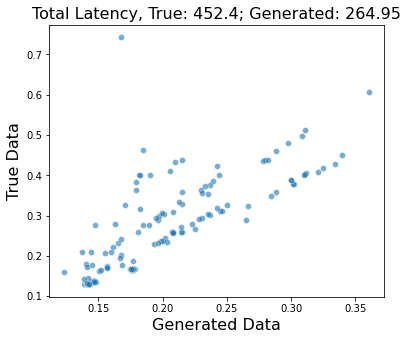

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
true_rt = round(df.groupby(["data_kind"])["rt"].sum()["True Data"], 2)
gen_rt = round(df.groupby(["data_kind"])["rt"].sum()["Generated Data"], 2)

title = "Total Latency, True: {}; Generated: {}".format(true_rt, gen_rt)

sns.scatterplot(data=edf, x = "Generated Data", y="True Data", alpha=0.6, ax=ax)

ax.set_ylabel("True Data", fontsize=16)
ax.set_xlabel("Generated Data", fontsize=16)

plt.title(title, fontsize=16)

#FN= "{}-{}-scatterplot.pdf".format(INP , NUMQ)
#plt.savefig(FN, bbox_inches="tight")
plt.show()